In [1]:
import kagglehub
import os

path = kagglehub.dataset_download('rohitgrewal/airlines-flights-data')
print('Path Dataset berada di :', path)
print('Isi Folder :', os.listdir(path))

Using Colab cache for faster access to the 'airlines-flights-data' dataset.
Path Dataset berada di : /kaggle/input/airlines-flights-data
Isi Folder : ['airlines_flights_data.csv']


In [2]:
import pandas as pd

df = pd.read_csv(path + '/airlines_flights_data.csv')
df

,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...,...
300148,300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [3]:
df.drop(columns='index', inplace=True)
df.head(5)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [4]:
df.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')

In [5]:
Features = ['source_city','departure_time','stops','arrival_time','destination_city','class','days_left']

In [6]:
fitur = df[Features]
target = df['price']

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    fitur, target, test_size=0.2, random_state=42
)

In [8]:
print(f"Data training berjumlah {len(X_train)} dan data uji berjumlah {len(X_test)}")

Data training berjumlah 240122 dan data uji berjumlah 60031


**PREPROCESSING**

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer

scaler = StandardScaler()
num_feat = ['days_left']
num_transform = scaler

In [10]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_feat = ['source_city','departure_time','stops','arrival_time','destination_city']
cat_transform = encoder

In [11]:
ordinal_features = ['class']
class_categories = ['Economy','Business']
ordinal_transofrm = OrdinalEncoder(categories=[class_categories])

In [12]:
import numpy as np

log_transform = FunctionTransformer(np.log1p, inverse_func=np.expm1)

In [13]:
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('log', log_transform),
            ('scaler', scaler)]), num_feat),
        ('ord', ordinal_transofrm, ordinal_features),
        ('cat', cat_transform, cat_feat)
    ], remainder='drop'
)

**HYPERPARAMETER TUNING**

In [14]:
from sklearn.linear_model import Ridge

model_ridge = Ridge()

In [15]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', TransformedTargetRegressor(
        regressor= model_ridge,
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

In [16]:
params_grid = {
    'regressor__regressor__alpha' : [0.001, 0.01, 0.1, 1, 10, 100]
}

In [17]:
from sklearn.model_selection import GridSearchCV

grid_ridge = GridSearchCV(
    estimator=pipeline,
    param_grid=params_grid,
    cv = 5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

In [18]:
grid_ridge.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              inverse_func=<ufunc 'expm1'>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['days_left']),
                                                                        ('ord',
                                                                         OrdinalEncoder(categories=[['Economy',
                                                                                                     'Business']]),
                                                                         ['class']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['source_city',
                                                                          'departure_time',
                                                                          'stops',
                                                                          'arrival_time',
                                                                          'destination_city'])])),
                                       ('regressor',
                                        TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                   inverse_func=<ufunc 'expm1'>,
                                                                   regressor=Ridge()))]),
             n_jobs=-1,
             param_grid={'regressor__regressor__alpha': [0.001, 0.01, 0.1, 1,
                                                         10, 100]},
             scoring='r2', verbose=1)

In [19]:
best_model = grid_ridge.best_estimator_

**EVALUATE**

In [20]:
print("\n Best alpha:", grid_ridge.best_params_)
print("Best R2 Score (CV) :", grid_ridge.best_score_)


 Best alpha: {'regressor__regressor__alpha': 100}
Best R2 Score (CV) : 0.8487280290869892


In [21]:
print(best_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['days_left']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['Economy',
                                                                              'Business']]),
                                                  ['class']),
                                                 ('cat',
                   

In [22]:
y_pred = best_model.predict(X_test)

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('\n -- Hasil Evaluasi pada Data Uji --')
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE (Root Mean Squared Error) : {rmse:.4f}')
print(f'MAE (Mean Absolute Error) : {mae:.4f}')
print(f'R-Squared (R2 Score) : {r2:.4f}')
print(f'Harga Aktual pada Data Uji : \n {y_test.values}')
print(f'Harga Prediksi dalam Skala Asli : \n{np.round(y_pred,2)}')


 -- Hasil Evaluasi pada Data Uji --
RMSE (Root Mean Squared Error) : 8806.0955
MAE (Mean Absolute Error) : 4908.6411
R-Squared (R2 Score) : 0.8496
Harga Aktual pada Data Uji : 
 [ 7366 64831  6195 ...  6734  5082 66465]
Harga Prediksi dalam Skala Asli : 
[ 4962.59 51615.78  6159.64 ...  5477.31  3128.31 88980.46]


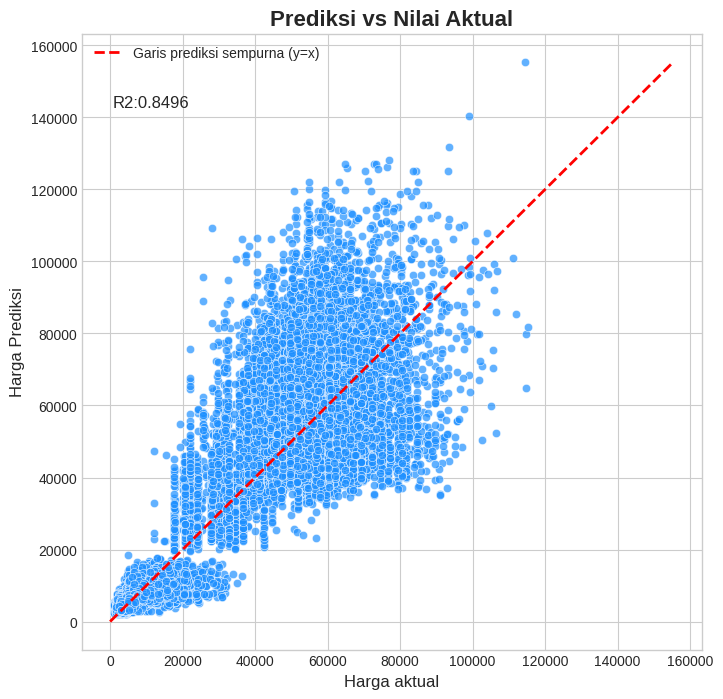

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

seaborn_version = 'seaborn-v0_8-whitegrid'

plt.figure(figsize=(8,8))
plt.style.use(seaborn_version)

sns.scatterplot(x=y_test, y=y_pred, color='dodgerblue', alpha=0.7)
max_val = max(y_test.max(), y_pred.max())
y_pred.max()

plt.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Garis prediksi sempurna (y=x)')
plt.title('Prediksi vs Nilai Aktual', fontsize=16, fontweight='bold')
plt.xlabel('Harga aktual', fontsize=12)
plt.ylabel('Harga Prediksi', fontsize=12)
plt.legend()
plt.text(0.05, 0.9, f'R2:{r2:.4f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')
plt.show()

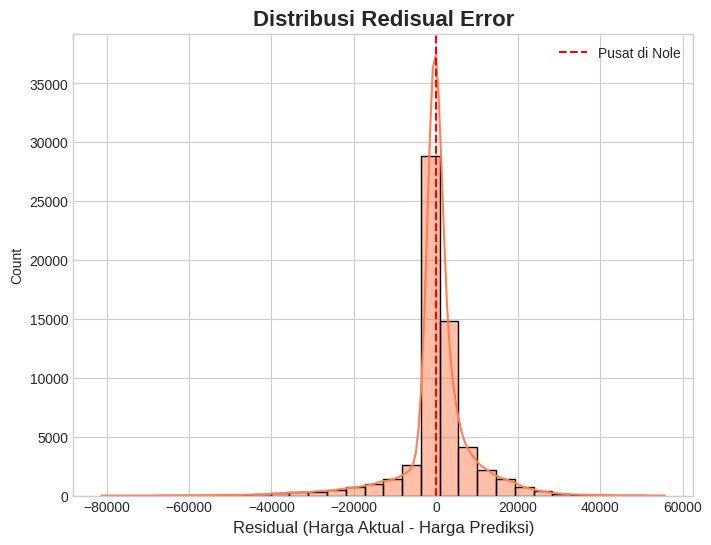

In [28]:
residual = y_test - y_pred

plt.figure(figsize=(8,6))
plt.style.use(seaborn_version)

sns.histplot(residual, kde=True, color='coral', bins=30)
plt.title('Distribusi Redisual Error', fontsize=16, fontweight='bold')
plt.xlabel('Residual (Harga Aktual - Harga Prediksi)', fontsize=12)
plt.axvline(0, color='r', linestyle='--', label='Pusat di Nole')
plt.legend()
plt.show()

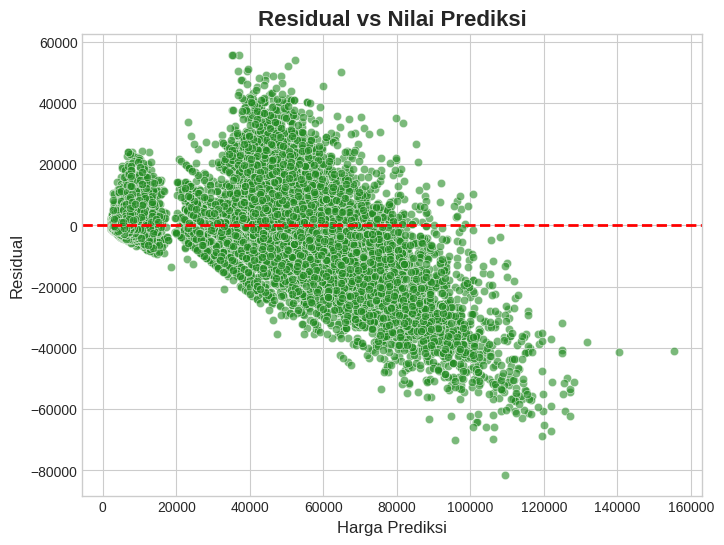

In [29]:
plt.figure(figsize=(8,6))
plt.style.use(seaborn_version)

sns.scatterplot(x=y_pred, y=residual, color='forestgreen', alpha=0.6)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.title('Residual vs Nilai Prediksi', fontsize=16, fontweight='bold')
plt.xlabel('Harga Prediksi', fontsize=12)
plt.ylabel('Residual', fontsize=12)
plt.show()

In [30]:
# --- Fungsi untuk ambil nama fitur dari preprocessor ---
def get_feature_names_from_column_transformer(ct):
    feature_names = []

    for name, trans, cols in ct.transformers_:
        if name == 'remainder':
            continue

        if hasattr(trans, 'steps'):
            last_step = trans.steps[-1][1]
            if hasattr(last_step, 'get_feature_names_out'):
                names = last_step.get_feature_names_out(cols)
            else:
                names = cols
        elif hasattr(trans, 'get_feature_names_out'):
            names = trans.get_feature_names_out(cols)
        else:
            names = cols

        feature_names.extend(names)

    return feature_names


In [34]:
# --- Ambil nama fitur dan koefisien dari pipeline ---
preprocessor = best_model.named_steps['preprocessor']
nama_fitur = get_feature_names_from_column_transformer(preprocessor)

In [36]:
# Ambil koefisien dari model Linear Regression di dalam TransformedTargetRegressor
koef = best_model.named_steps['regressor'].regressor_.coef_

In [37]:
# --- Buat DataFrame Feature Importance ---
df_importance = pd.DataFrame({
    'Feature': nama_fitur,
    'Coefficient': koef
}).sort_values(by='Coefficient', ascending=False)

print(df_importance.head(20))

                         Feature  Coefficient
1                          class     2.149192
15             stops_two_or_more     0.327235
6            source_city_Kolkata     0.140447
14                     stops_one     0.109371
27      destination_city_Kolkata     0.101650
19          arrival_time_Evening     0.079430
22            arrival_time_Night     0.064207
12        departure_time_Morning     0.044497
21          arrival_time_Morning     0.033746
9   departure_time_Early_Morning     0.016257
13          departure_time_Night     0.012964
23    destination_city_Bangalore     0.011480
17        arrival_time_Afternoon     0.008428
2          source_city_Bangalore     0.007073
10        departure_time_Evening     0.006716
28       destination_city_Mumbai    -0.004581
24      destination_city_Chennai    -0.019137
25        destination_city_Delhi    -0.020014
3            source_city_Chennai    -0.021468
8       departure_time_Afternoon    -0.024747


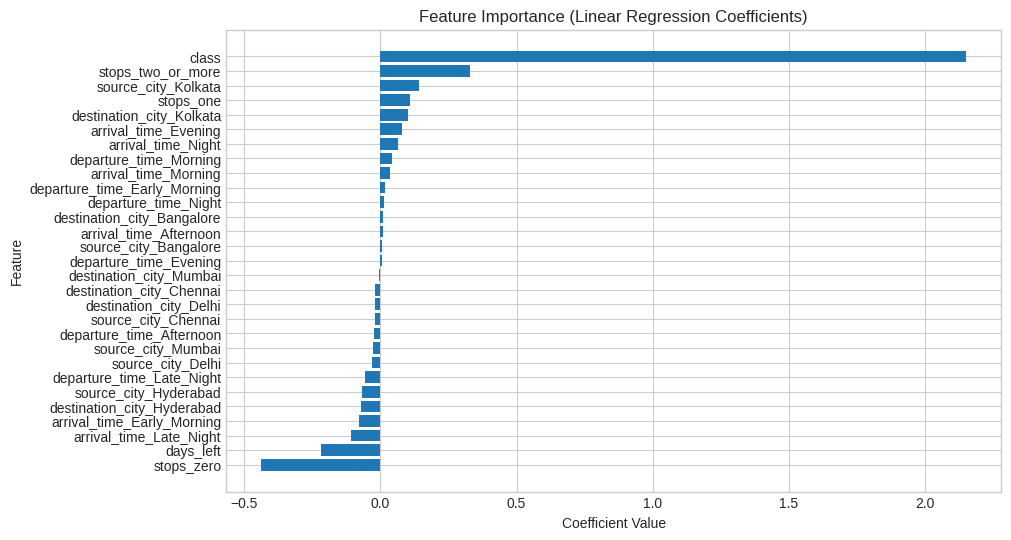

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(df_importance['Feature'], df_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Linear Regression Coefficients)')
plt.gca().invert_yaxis()
plt.show()


In [39]:
from google.colab import files
import joblib

joblib.dump(best_model, 'Ridge_regressor_prediction_flight_price.pkl')

['Ridge_regressor_prediction_flight_price.pkl']

In [40]:
files.download('Ridge_regressor_prediction_flight_price.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>